In [32]:
import pandas as pd 
import cv2, numpy as np
import idx2numpy as idx
from matplotlib import pyplot as plt
%matplotlib inline

# keras
np.random.seed(13)
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Reshape, Activation, SimpleRNN, GRU, LSTM, Convolution1D, \
                         MaxPooling1D, Merge, Dropout, Input
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
#from keras.utils.visualize_util import model_to_dot, plot
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras import backend as K
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist

# logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
def VGG16(weights_path=None, include_top=False, input_tensor=None):

    input_shape = (3, 224, 224)
        
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
            
    # Block 1
    x = Convolution2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Convolution2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Convolution2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Convolution2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Convolution2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Convolution2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(1000, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(img_input, x)

    # load weights
    if weights_path:
        model.load_weights(weights_path)
            
    return model

In [3]:
def prepare_image(image_path):
    im = cv2.resize(cv2.imread(image_path), (224, 224)).astype(np.float32)

    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = im.transpose((2,0,1))
    im = np.expand_dims(im, axis=0)
    return im

### build cnn model based on vgg16

In [22]:
K.set_image_dim_ordering('th') # use tf if backend is TensorFlow
model = VGG16(weights_path='../vgg16/vgg16_weights_th_dim_ordering_th_kernels.h5', include_top=True)
# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(optimizer=sgd, loss='categorical_crossentropy')

In [28]:
# removes final layers
for i in range(4):
    model.layers.pop()

In [12]:
# Freeze convolutional layers
for layer in model.layers:
    layer.trainable = False

In [31]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

In [13]:
x = model.output
x = Dropout(0.5)(x)
# model.add(Dropout(0.5))
# model.add(Dense(2))# must match the number of classes you are predicting
# model.add(Activation('softmax'))
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
#               loss='categorical_crossentropy', metrics=['accuracy'])

AttributeError: 'Model' object has no attribute 'add'

### import and clean data

In [4]:
# 4. Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11386880/11490434 [============================>.] - ETA: 0s

In [ ]:
# 5. Preprocess input data
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
# 6. Preprocess class labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

### model training

In [ ]:
model.fit(X_train, Y_train, 
          batch_size=32, nb_epoch=10, verbose=1)

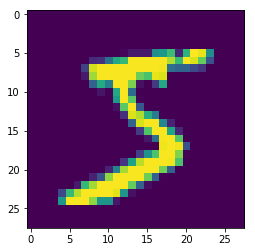

In [5]:
plt.imshow(y_train[0])

In [7]:
Y_test = np_utils.to_categorical(y_test, 10)
Y_test[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

In [9]:
y_test[0]

7

In [18]:
all_img = idx.convert_from_file('../MnistData/t10k-images-idx3-ubyte')
img1 = all_img[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [15]:
img = prepare_image('../MnistData/t10k-images-idx3-ubyte')

error: /home/travis/miniconda/conda-bld/conda_1485299292920/work/opencv-3.2.0/modules/imgproc/src/imgwarp.cpp:3492: error: (-215) ssize.width > 0 && ssize.height > 0 in function resize


In [ ]:
out = model.predict(img)
y_pred = np.argmax(out)

In [ ]:
synset = pd.read_csv('synset_words.txt', skipinitialspace=True, names = ['synset', 'words'])
